In [2]:
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
%matplotlib inline

In [3]:
da = xr.open_rasterio("landsat/RGB_subset_2014-04-26-ac.png")

/Users/hannah/miniconda3/envs/geo/lib/python3.6/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


In [4]:
da

<xarray.DataArray (band: 3, y: 815, x: 921)>
[2251845 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Attributes:
    transform:   (0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
    res:         (1.0, -1.0)
    is_tiled:    0
    nodatavals:  (nan, nan, nan)

In [5]:
lat_lon = np.genfromtxt('landsat/landsat_latlon_2014-04-26.txt', skip_header=6)

In [6]:
coords = lat_lon.reshape((2,815,921))

In [7]:
coords[0]

array([[40.8796, 40.8796, 40.8796, ..., 40.8749, 40.8749, 40.8749],
       [40.8794, 40.8794, 40.8793, ..., 40.8746, 40.8746, 40.8746],
       [40.8791, 40.8791, 40.8791, ..., 40.8743, 40.8743, 40.8743],
       ...,
       [40.6602, 40.6602, 40.6602, ..., 40.6554, 40.6554, 40.6554],
       [40.6599, 40.6599, 40.6599, ..., 40.6552, 40.6552, 40.6552],
       [40.6597, 40.6596, 40.6596, ..., 40.6549, 40.6549, 40.6549]])

In [8]:
coords[1]

array([[-74.0664, -74.0661, -74.0657, ..., -73.7373, -73.7369, -73.7366],
       [-74.0664, -74.0661, -74.0657, ..., -73.7373, -73.7369, -73.7366],
       [-74.0664, -74.0661, -74.0657, ..., -73.7373, -73.7369, -73.7366],
       ...,
       [-74.0674, -74.067 , -74.0666, ..., -73.7382, -73.7378, -73.7375],
       [-74.0674, -74.067 , -74.0666, ..., -73.7382, -73.7378, -73.7375],
       [-74.0674, -74.067 , -74.0666, ..., -73.7382, -73.7378, -73.7375]])

In [9]:
da.coords['lat'] = (('y', 'x'), coords[0])
da.coords['lon'] = (('y', 'x'), coords[1])

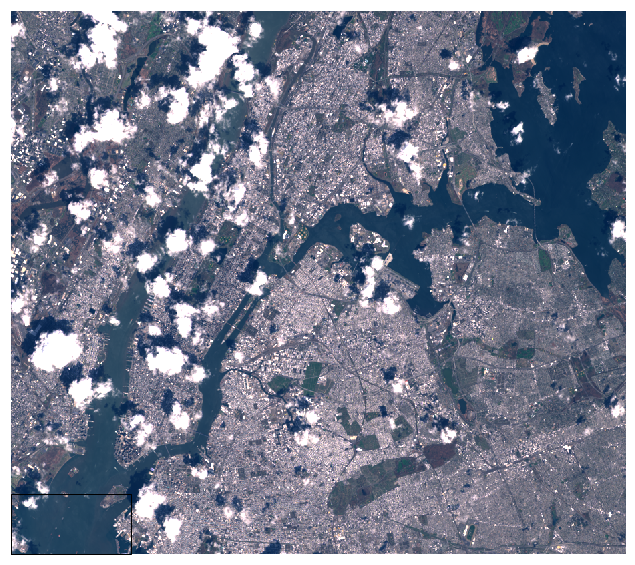

In [31]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, 
                       figsize=(20,10))
ax.imshow(da.transpose('y', 'x', 'band').values[::-1], transform=ccrs.PlateCarree())
plt.show()

In [11]:
# Compute a greyscale out of the rgb image
grayscale = da.mean(dim='band')

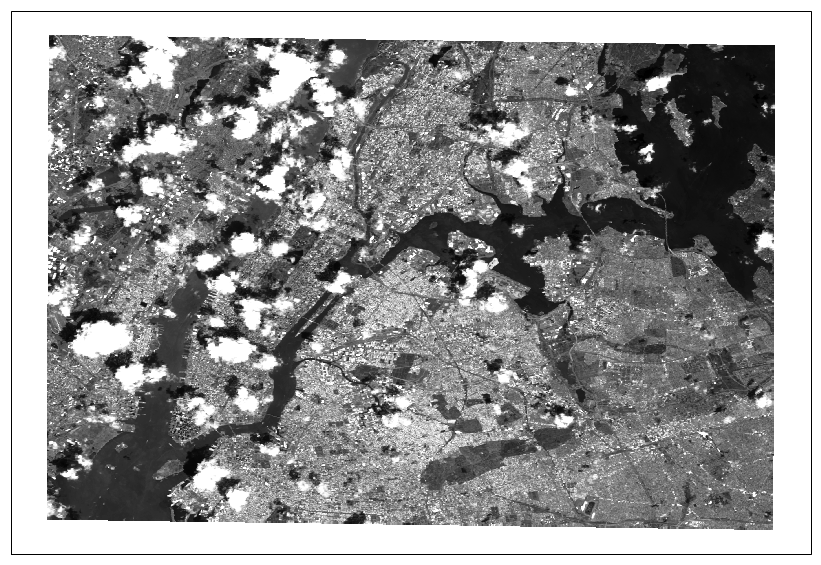

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, 
                       figsize=(20,10))
grayscale.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
               cmap='Greys_r', add_colorbar=False)
plt.show()

In [36]:
# let's try to find clouds?
# http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

In [37]:
@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)

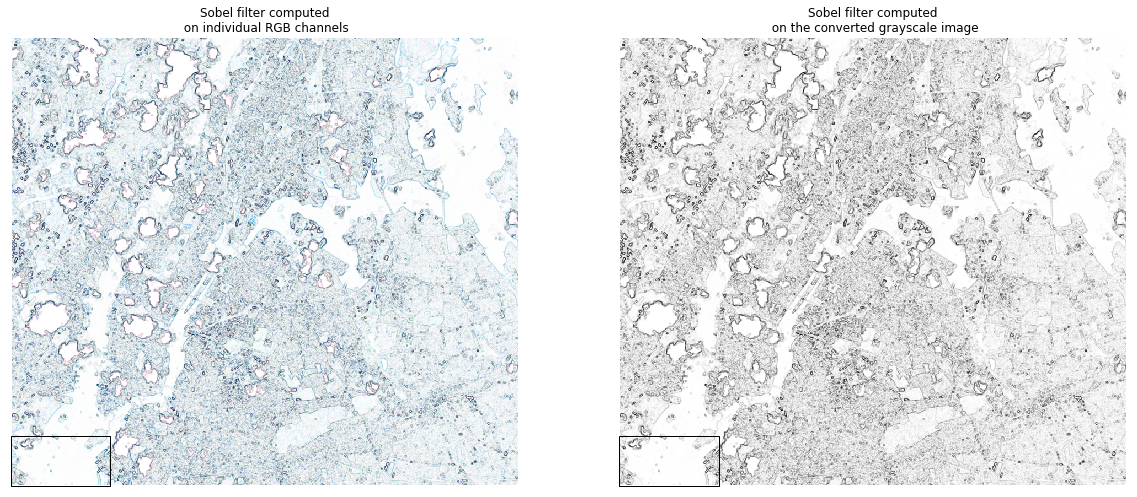

In [40]:
fig, (ax1, ax2) = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, 
                               ncols=2, figsize=(20,10))

# We use 1 - sobel_each(image) but this won't work if image is not normalized
ax1.imshow(rescale_intensity(1 - sobel_each(da.transpose('y', 'x', 'band').values[::-1])), 
          transform=ccrs.PlateCarree())
ax1.set_title("Sobel filter computed\n on individual RGB channels")

ax2.imshow(rescale_intensity(1 - sobel_gray(da.transpose('y', 'x', 'band').values[::-1])), 
          transform=ccrs.PlateCarree(), cmap="gray")
ax2.set_title("Sobel filter computed\n on the converted grayscale image")
plt.show()